<a href="https://colab.research.google.com/github/lucijatopic/NAR/blob/main/Seminar_NAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install CUDA
!apt-get update
!apt-get install -y --no-install-recommends \
    cuda-10-1 \
    libcudnn7=7.6.5.32-1+cuda10.1  \
    libcudnn7-dev=7.6.5.32-1+cuda10.1

# Install OpenCV
!apt-get install -y libopencv-dev python3-opencv

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package cuda-10-1
E: Unable to locate package libcudnn7
E: Unable to locate package libcudnn7-dev
Reading package list

In [2]:
# Check CUDA version
!nvcc --version

# Check GPU status
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
/bin/bash: line 1: nvidia-smi: command not found


In [1]:
%%writefile minimum_filter.cu
#include <stdio.h>
#include <stdlib.h>
#include <opencv2/opencv.hpp>
using namespace cv;

// Kernel function to apply the 7x7 minimum filter
__global__ void minimumFilter(uchar* input, uchar* output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    int halfFilterWidth = 3; // Half of 7x7
    uchar minVal[3] = {255, 255, 255}; // Initial minimum values for RGB

    // Iterate through the 7x7 window
    for (int ky = -halfFilterWidth; ky <= halfFilterWidth; ky++) {
        for (int kx = -halfFilterWidth; kx <= halfFilterWidth; kx++) {
            int nx = x + kx;
            int ny = y + ky;

            // Ensure the indices are within image boundaries
            if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
              //ažurira minVal za svaki RGB kanal (c) s minimalnom vrijednošću pronađenom unutar prozora filtra.
                for (int c = 0; c < 3; c++) {
                    minVal[c] = min(minVal[c], input[(ny * width + nx) * 3 + c]);
                }
            }
        }
    }
    // Zapisivanje minimalnih vrijednosti u izlaznu sliku
    for (int c = 0; c < 3; c++) {
        output[(y * width + x) * 3 + c] = minVal[c];
    }
}

int main(int argc, char** argv) {
    if (argc != 2) {
        printf("usage: minimum_filter.out <Image_Path>\n");
        return -1;
    }

    Mat image = imread(argv[1], IMREAD_COLOR);
    if (image.empty()) {
        printf("Could not open or find the image\n");
        return -1;
    }

    int height = image.rows;
    int width = image.cols;
    size_t sizeInBytes = image.total() * image.elemSize();
    printf("slika je veličine %zu bytes\n", sizeInBytes);
    printf("slika je veličine %i x %i\n", height, width);

    uchar* d_input = NULL;
    uchar* d_output = NULL;

    if (cudaMalloc((void**)&d_input, sizeInBytes) != cudaSuccess || cudaMalloc((void**)&d_output, sizeInBytes) != cudaSuccess) {
        printf("CUDA allocation error\n");
        return -1;
    }

    if (cudaMemcpy(d_input, image.ptr<uchar>(0), sizeInBytes, cudaMemcpyHostToDevice) != cudaSuccess) {
        printf("CUDA copy error\n");
        return -1;
    }

    dim3 blockDim(16, 16);
    dim3 gridDim((width + blockDim.x - 1) / blockDim.x, (height + blockDim.y - 1) / blockDim.y);

    minimumFilter<<<gridDim, blockDim>>>(d_input, d_output, width, height);
    cudaDeviceSynchronize();

    uchar* h_output = (uchar*)malloc(sizeInBytes);
    if (cudaMemcpy(h_output, d_output, sizeInBytes, cudaMemcpyDeviceToHost) != cudaSuccess) {
        printf("CUDA copy error\n");
        return -1;
    }

    Mat image_out = Mat(height, width, CV_8UC3, h_output);
    imwrite("output.jpg", image_out);

    cudaFree(d_input);
    cudaFree(d_output);
    free(h_output);

    return 0;
}


Writing minimum_filter.cu


In [3]:
!ls

Dubrovnik7.jpg	minimum_filter.cu  sample_data


In [4]:
from google.colab import files
# Compile the CUDA code
!nvcc -o minimum_filter minimum_filter.cu `pkg-config --cflags --libs opencv4` --expt-relaxed-constexpr -diag-suppress=611


In [5]:
# Run the CUDA program with the correct filename
!./minimum_filter Dubrovnik7.jpg

slika je veličine 6000000 bytes
slika je veličine 1000 x 2000


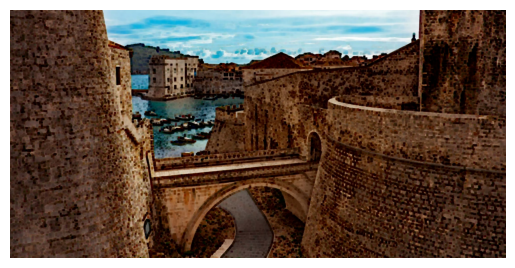

In [6]:
import cv2
from matplotlib import pyplot as plt

# Check if output image is created
import os
if os.path.exists('output.jpg'):
    output_image = cv2.imread('output.jpg')
    if output_image is not None:
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
    else:
        print("Error loading output image")
else:
    print("Output image not found")